In [1]:
from matplotlib import pyplot as plt

In [2]:
import math
import dill
from pyomo import environ as pyo

In [3]:
from importlib.resources import files

In [4]:
from interarray.interarraylib import G_from_S
from interarray.svg import svgplot
from interarray.plotting import pplot
from interarray.mesh import make_planar_embedding
from interarray.baselines.hgs import hgs_multiroot
from interarray.importer import L_from_yaml

In [5]:
from interarray.pathfinding import PathFinder

In [6]:
import interarray.MILP.pyomo as omo

In [7]:
%config InlineBackend.figure_formats = ['svg']
plt.rcParams['svg.fonttype'] = 'none'

## Reference solution

Cazzaro, D., & Pisinger, D. (2022). Balanced cable routing for offshore wind farms with obstacles. Networks, 80(4), 386–406. https://doi.org/10.1002/net.22100

In [8]:
G_ref = dill.load(open('cazzaro_2022_paper_routeset.dill', 'rb'))

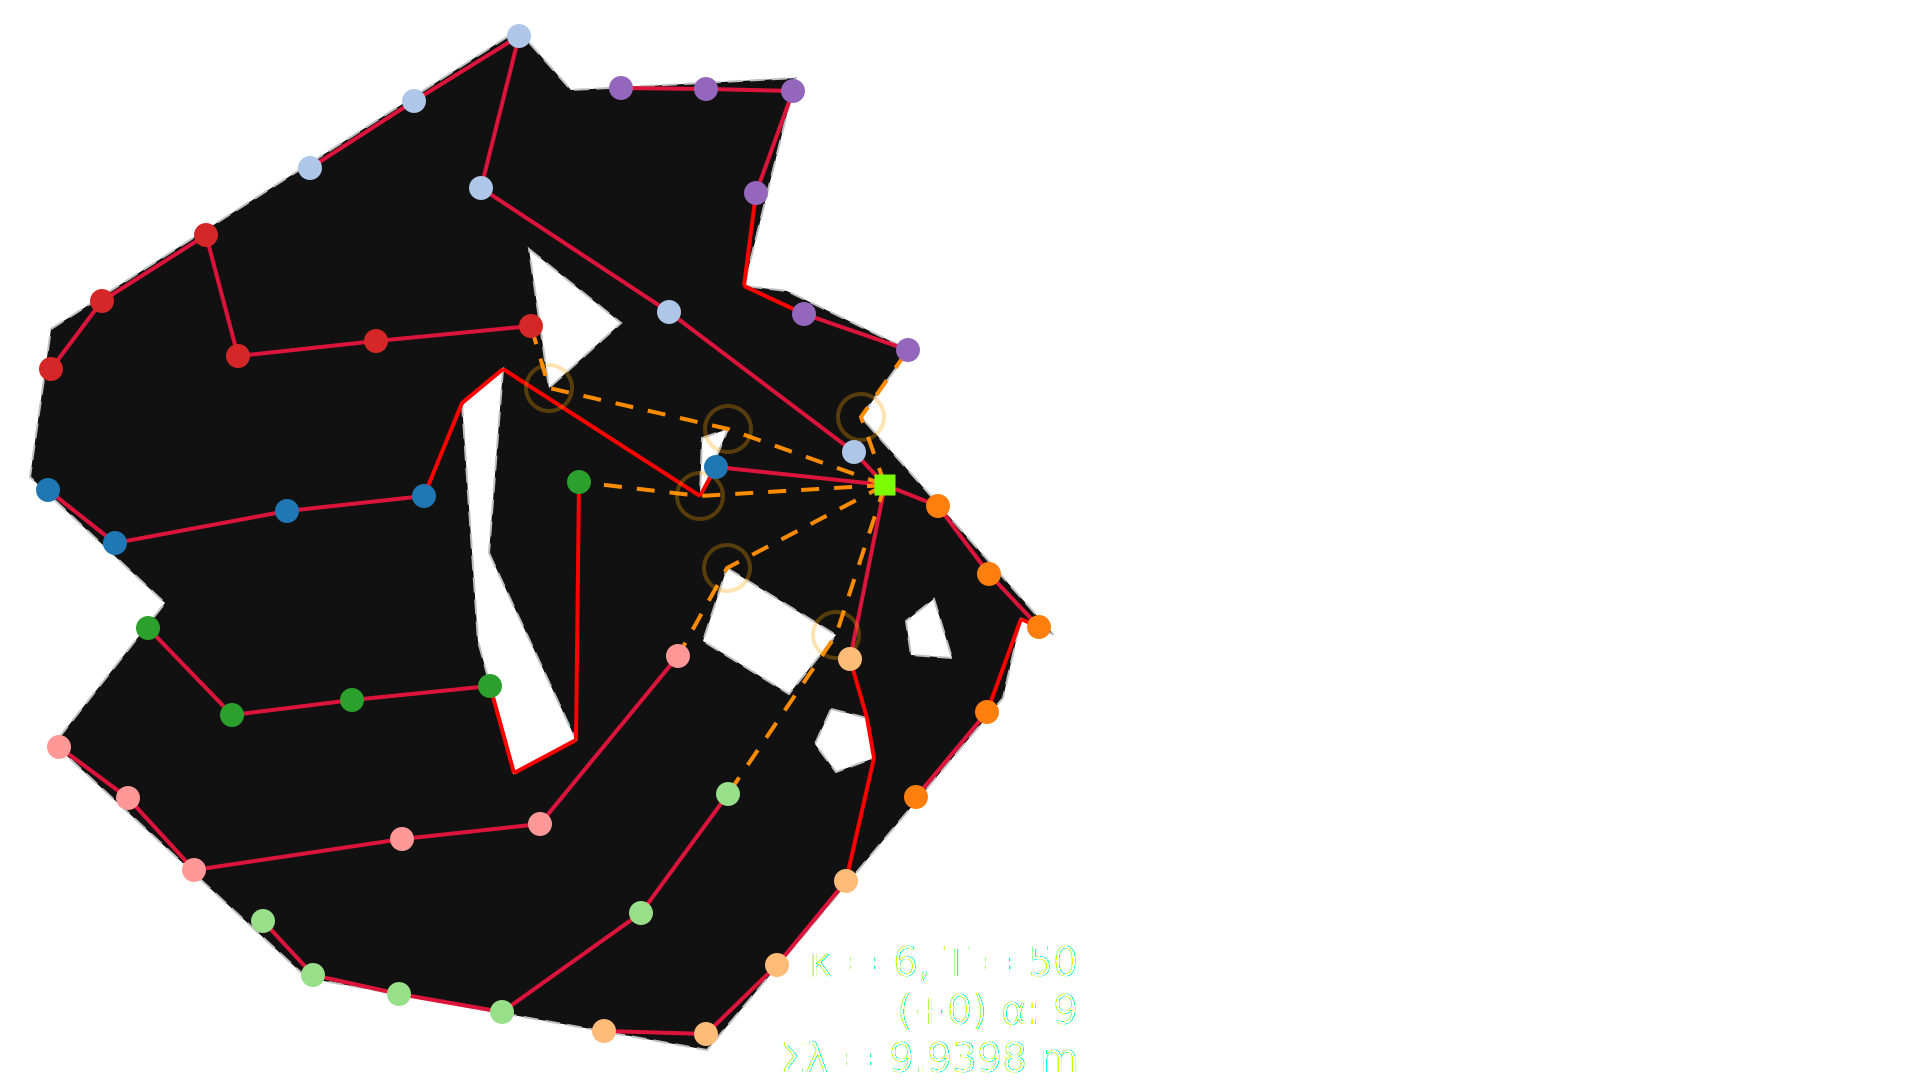

In [9]:
svgplot(G_ref)

## Start here

In [10]:
solver = pyo.SolverFactory('gurobi', solver_io='python')

In [11]:
L = L_from_yaml(files('interarray.data') / 'Cazzaro-2022.yaml')

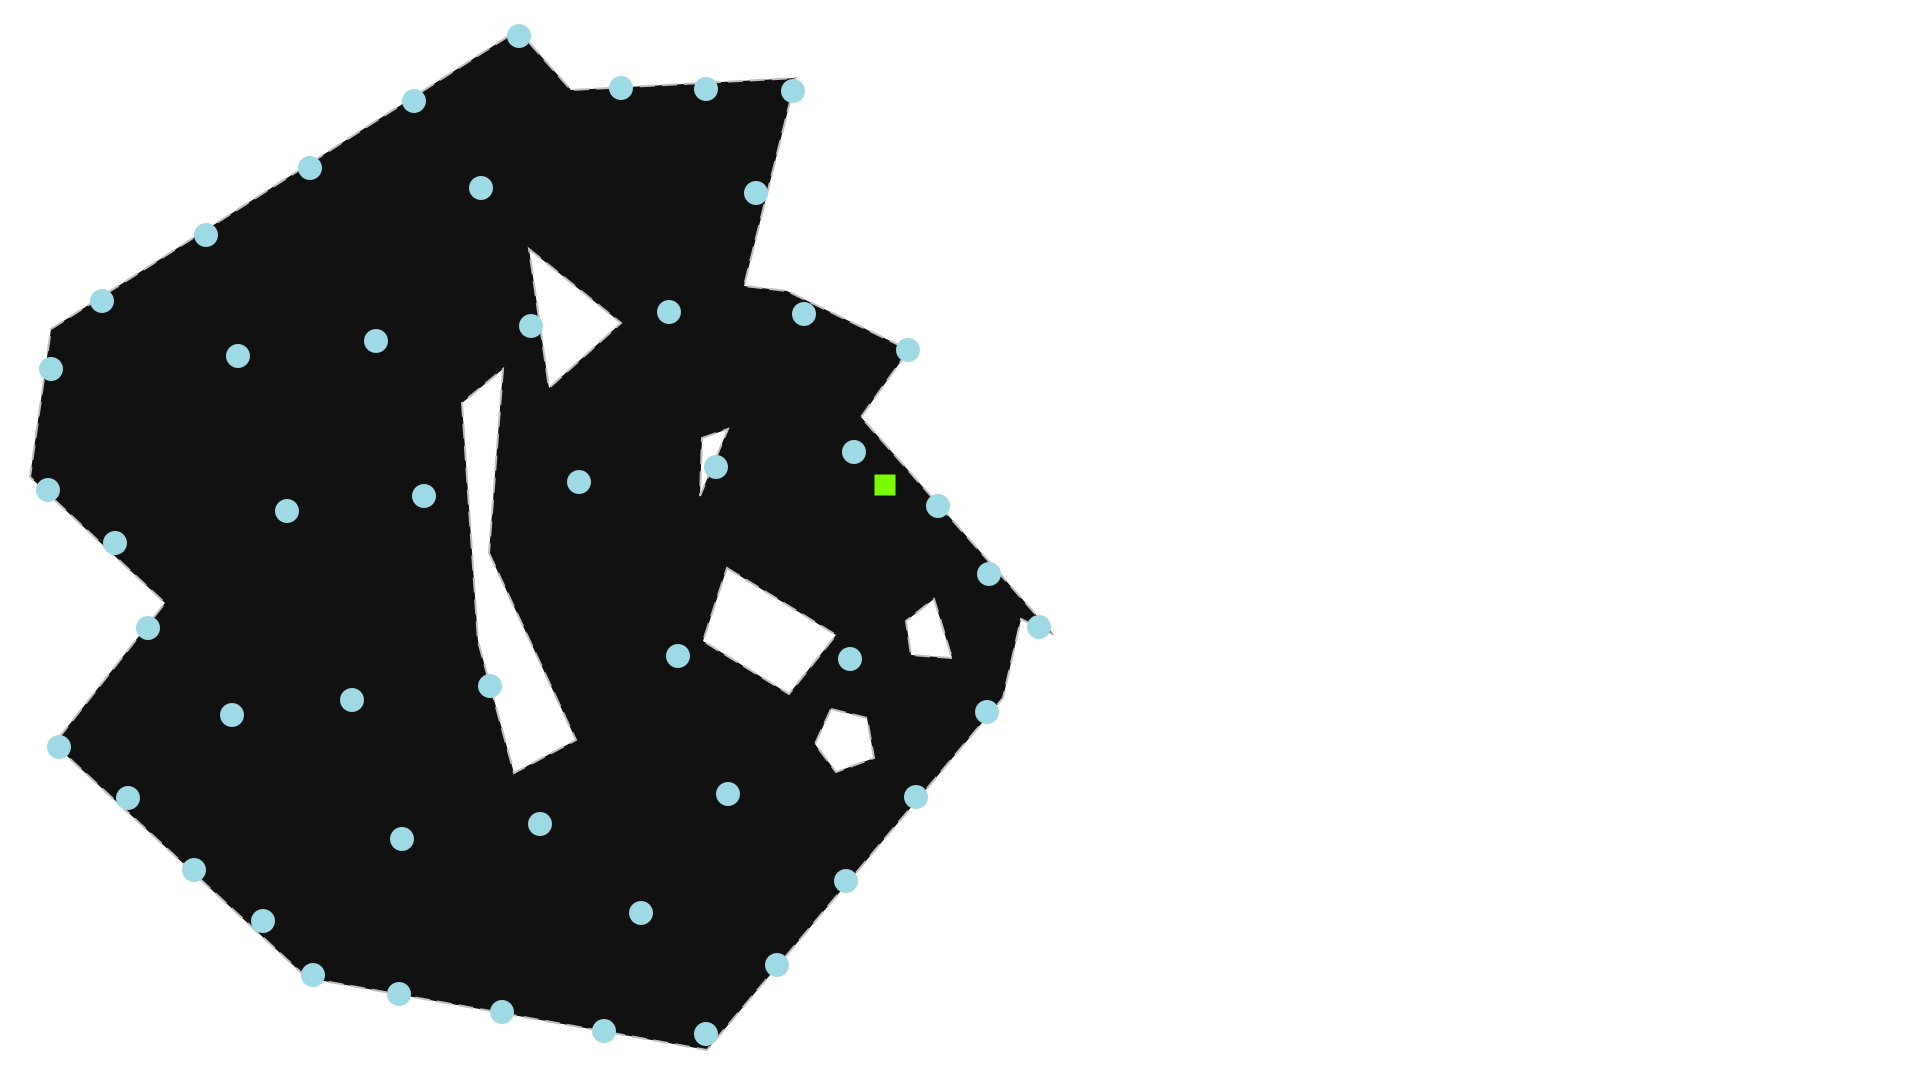

In [12]:
svgplot(L)

In [13]:
P, A = make_planar_embedding(L)

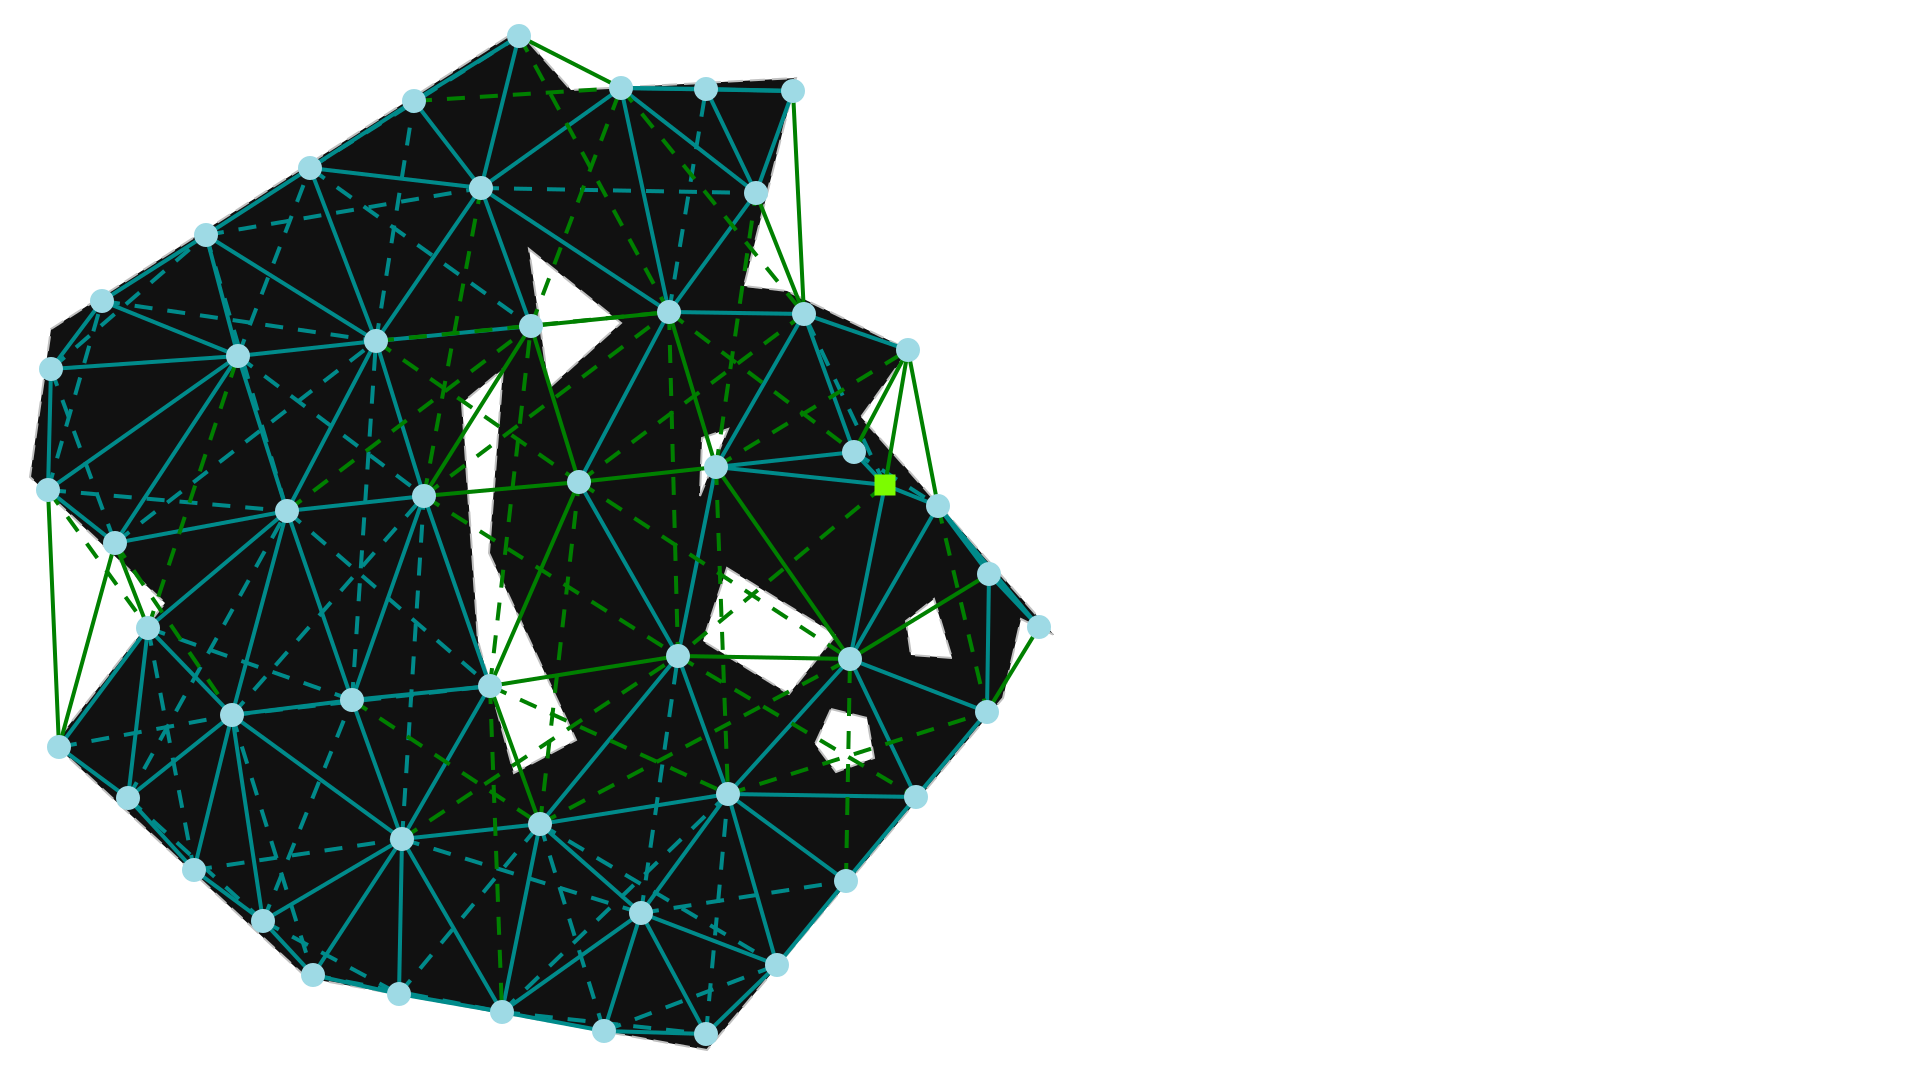

In [14]:
svgplot(A)

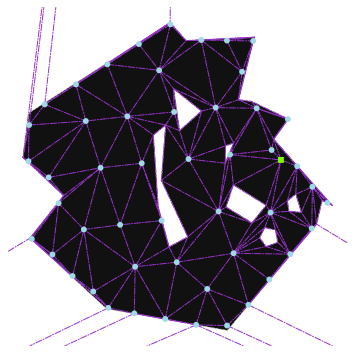

In [15]:
pplot(P, A);

## Pre-solve

In [16]:
Sʹ = hgs_multiroot(A, capacity=6, time_limit=0.5, balanced=True)

In [17]:
Sʹ.graph['solution_time']

(0.32,)

In [18]:
Gʹ = G_from_S(Sʹ, A)

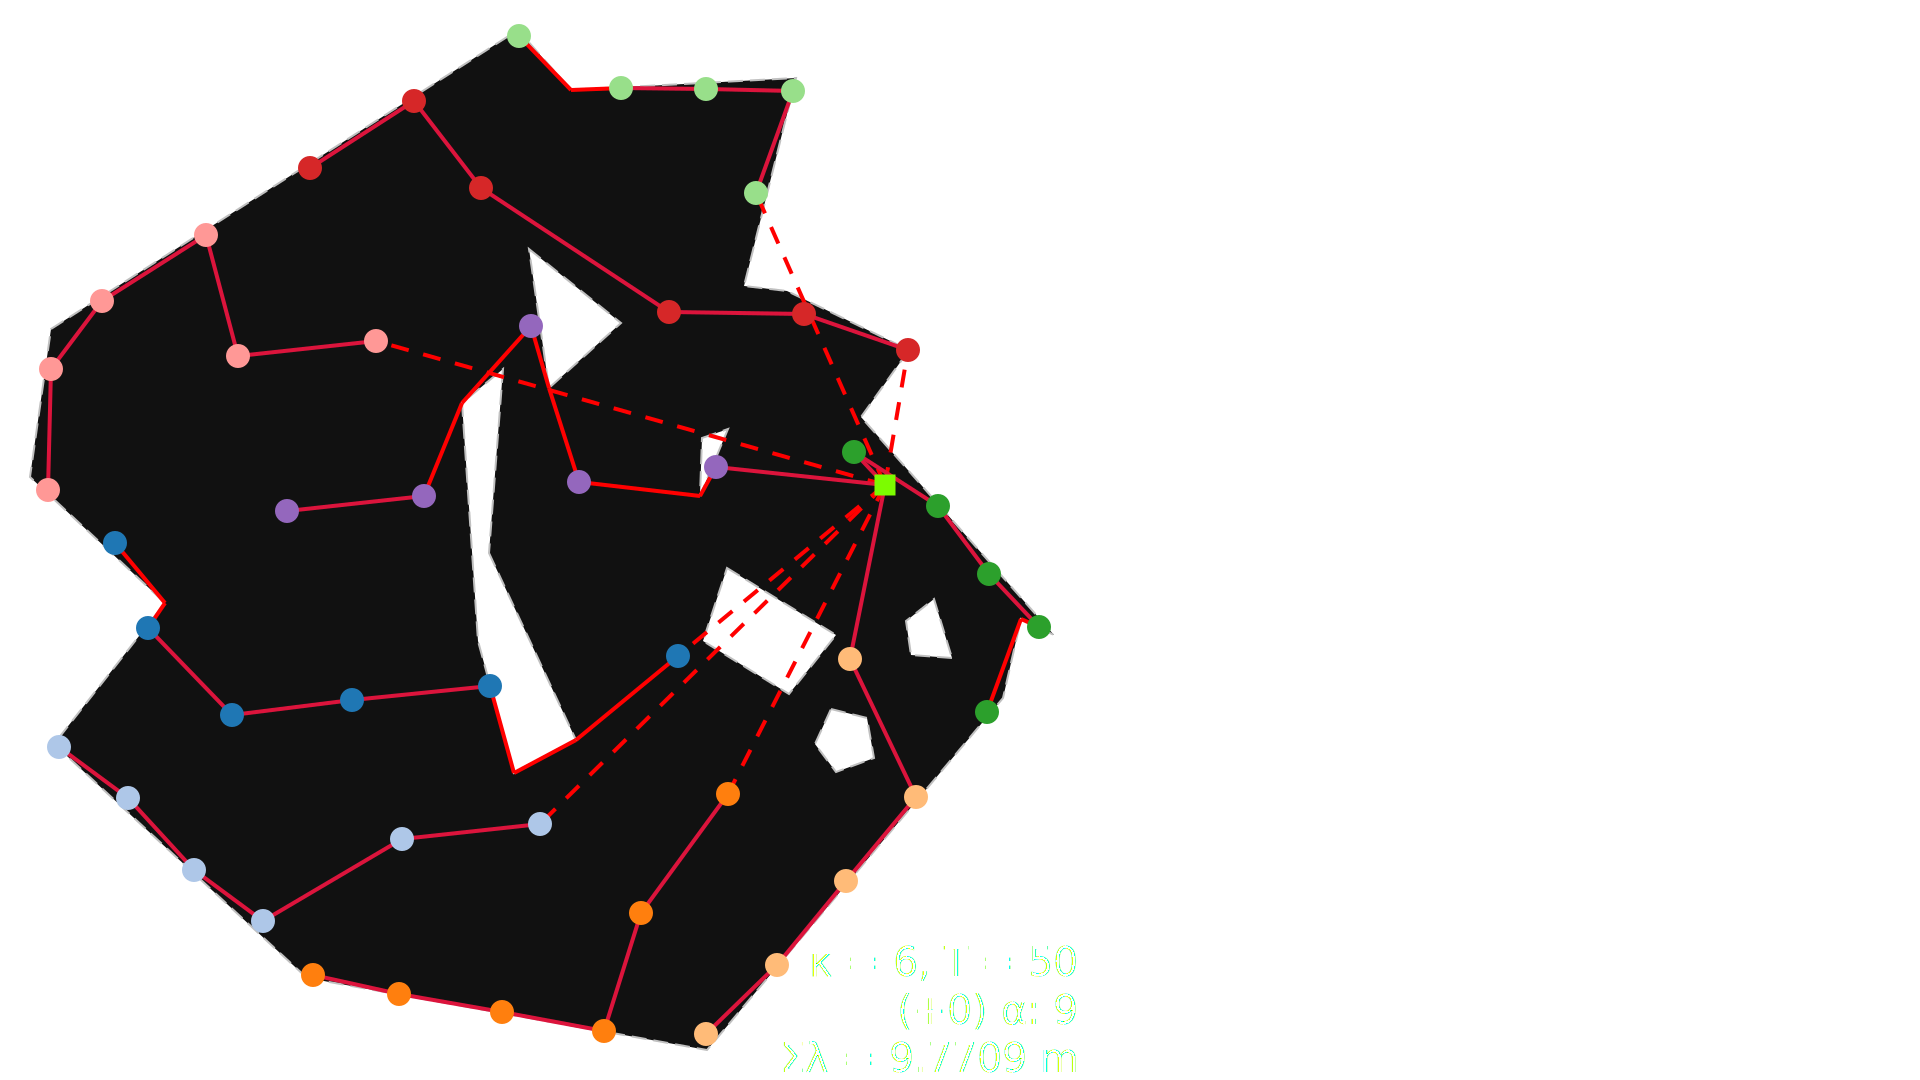

In [19]:
svgplot(Gʹ)

In [20]:
Hʹ = PathFinder(Gʹ, planar=P, A=A).create_detours()

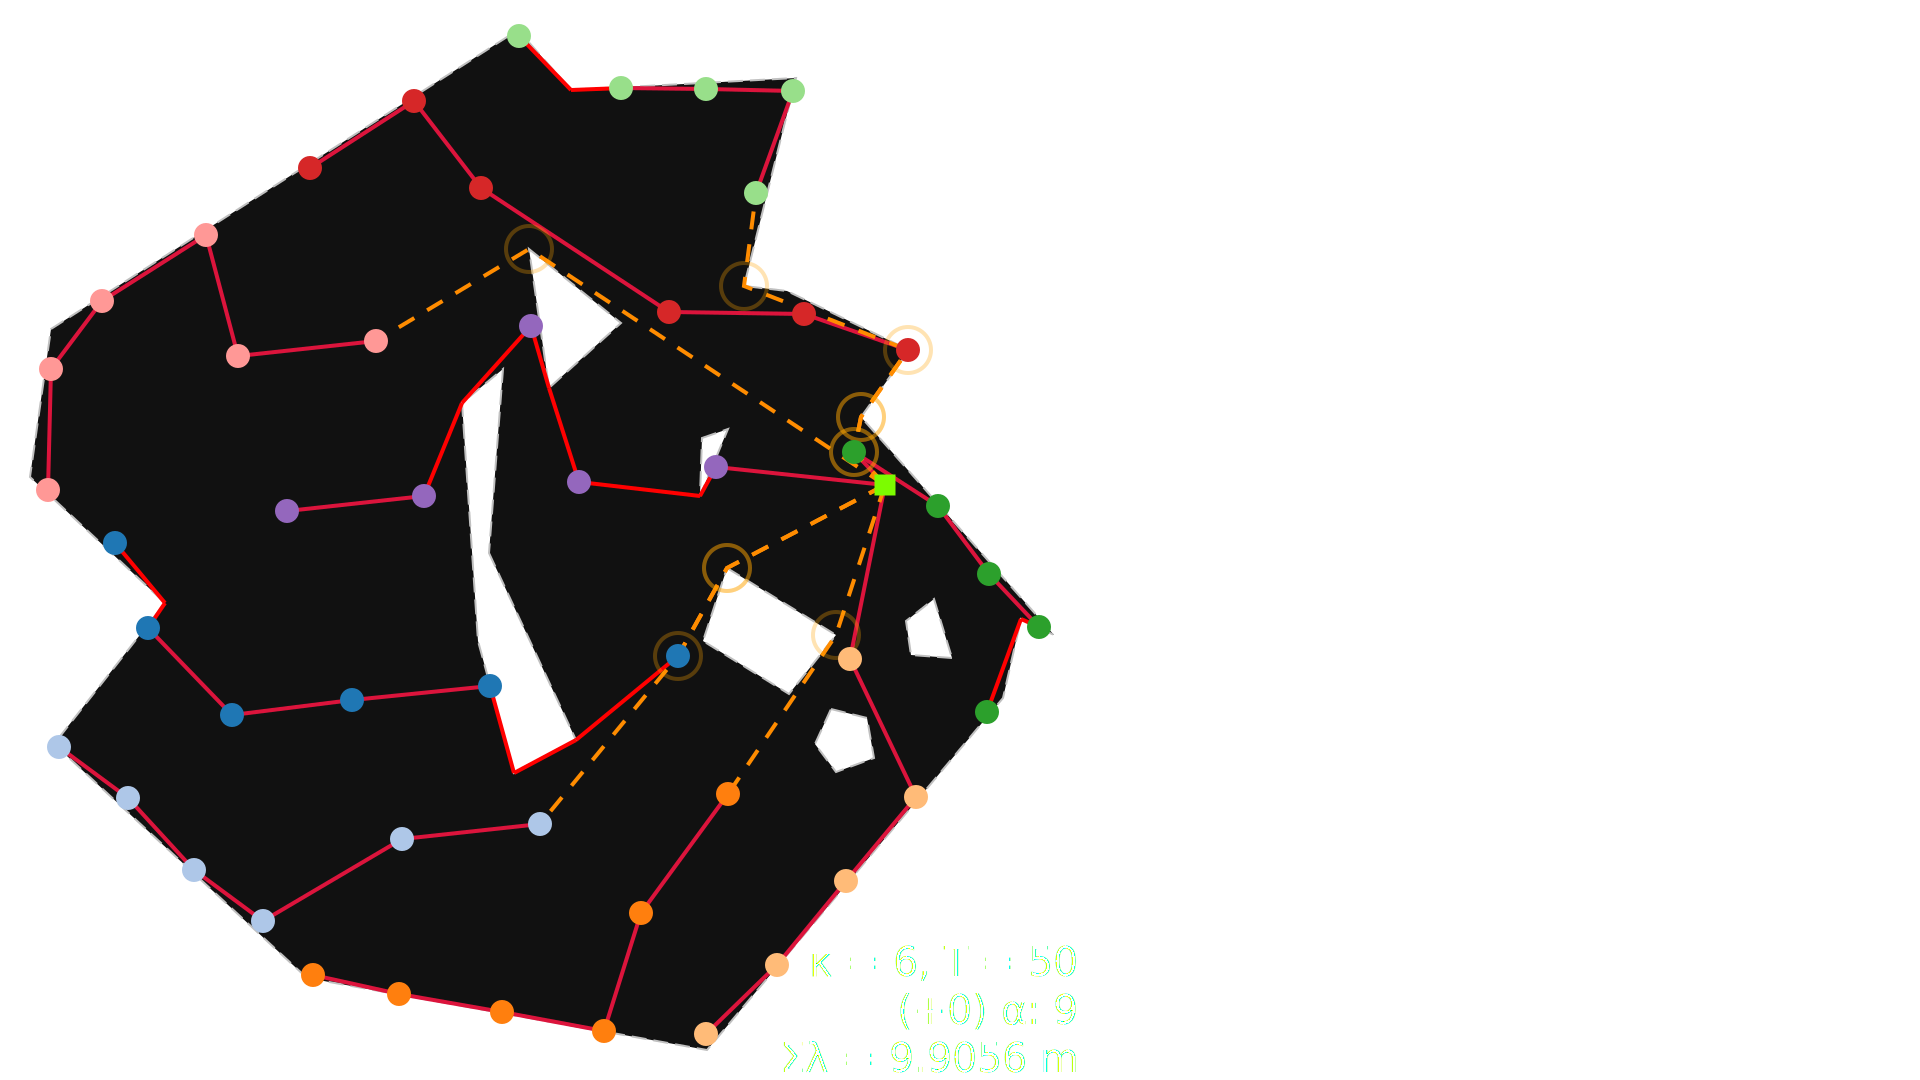

In [21]:
svgplot(Hʹ)

In [22]:
1 - Hʹ.size(weight='length')/G_ref.size(weight='length')

0.0034447624254382303

In [23]:
capacity = 6
# build model and pre-load solution from Sʹ
model = omo.make_min_length_model_balanced(
    A, capacity,
    num_gates=math.ceil(A.graph['T']/capacity),
    gateXings_constraint=False,
    branching=False
)
# omo.warmup_model_balanced(model, Sʹ)

In [24]:
solver.options.mipgap = 0.005  # 0.5 %
solver.options.timelimit = 10  # [s]
solver.options.mipfocus = 1  # focus on producing solutions
print(f'Solving "{model.handle}": {{R={len(model.R)}, T={len(model.T)}, k={model.k.value}}}\n')
status = solver.solve(model, warmstart=model.warmed_by, tee=True)

Solving "None": {R=1, T=50, k=6}

Set parameter OutputFlag to value 1
Set parameter MIPGap to value 0.005
Set parameter TimeLimit to value 10
Set parameter MIPFocus to value 1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
TimeLimit  10
MIPGap  0.005
MIPFocus  1

Academic license 937681 - for non-commercial use only - registered to ma___@dtu.dk
Optimize a model with 1333 rows, 864 columns and 5348 nonzeros
Model fingerprint: 0xb38844c9
Variable types: 0 continuous, 864 integer (482 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [6e-02, 1e+00]
  Bounds range     [1e+00, 5e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 193 rows and 0 columns
Presolve time: 0.01s
Presolved: 1140 rows, 864 columns, 4764 nonzero

In [25]:
H = omo.gurobi_investigate_pool_balanced(P, A, model, solver, status)

Solution pool has 8 solutions.
Incumbent has (detoured) length: 9.906
Incumbent has (detoured) length: 9.872
Incumbent has (detoured) length: 9.834
Pool investigation over - next best undetoured length: 9.859


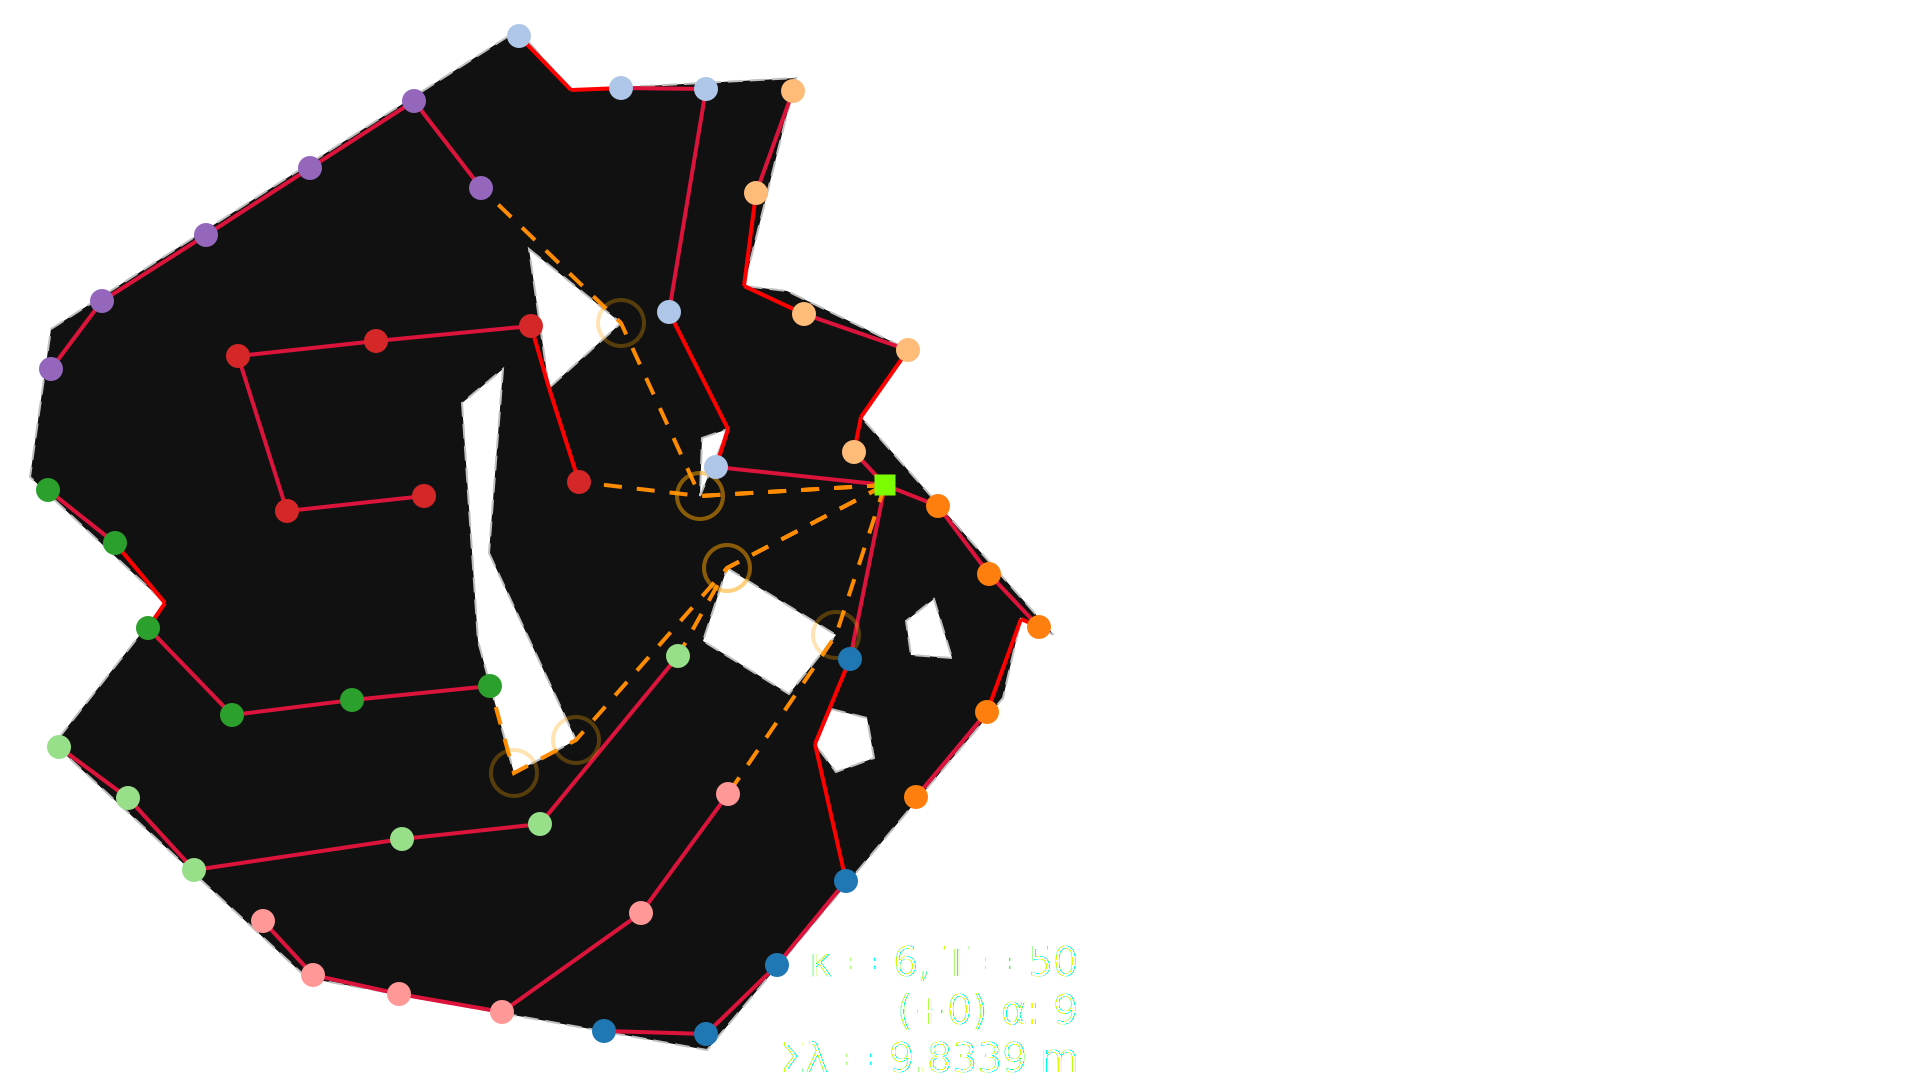

In [26]:
svgplot(H)

In [27]:
1 - H.size(weight='length')/G_ref.size(weight='length')

0.010658466350787599

In [28]:
with open('cazzaro_2022_comparison_κ_6_radial_balanced.dill', 'wb') as outfile:
    dill.dump(H, outfile)